# Demo. Injection, Enlarging, Shrinking Protocol

In [1]:
import stim
from typing import Tuple, Set, Dict, List
from numpy.typing import NDArray
import numpy as np
import sys
sys.path.append("../QEC-Codes")  # Adjust the path to import local modules
import surface_code as sf
import pymatching
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import seaborn as sns

### 1. Injection protocol
1.1. Corner Injection

In [2]:
def circuit_corner_injection(d: int, rounds: int, noise_profile: list[float], inject_state: str) -> stim.Circuit:
    
    p1, p2, p_M, p_R = noise_profile

    surface_code = sf.RotateSurfaceCode(d)

    full_circuit = stim.Circuit()

    coord_to_index = surface_code.coord_to_index
    data_coords = surface_code.data_coords
    ancilla_coords = surface_code.ancilla_coords
    ancilla_coords_z = surface_code.ancilla_coords_z
    ancilla_coords_x = surface_code.ancilla_coords_x

    # Add QUBIT_COORDS annotations
    for (x, y), index in coord_to_index.items():
        full_circuit.append('QUBIT_COORDS', [index], [x, y])

    # Initialization pattern
    lower_diagonal_data = []
    upper_diagonal_data = []

    for x, y in data_coords:
        if (x, y) == (1, 1):
            continue  # Corner qubit
        if y >= x:
            lower_diagonal_data.append((x, y))
        else:
            upper_diagonal_data.append((x, y))

    lower_indices = [coord_to_index[q] for q in lower_diagonal_data]
    upper_indices = [coord_to_index[q] for q in upper_diagonal_data]

    full_circuit.append_operation("RX", lower_indices)
    full_circuit.append_operation("Z_ERROR", lower_indices, p_R)
    full_circuit.append_operation("R", upper_indices)
    full_circuit.append_operation("X_ERROR", upper_indices, p_R)

    # Injected simulatable state into the corner qubit (|0> or |+>)
    corner = (1, 1)
    corner_index = coord_to_index[corner]
    if inject_state == "Z":
        full_circuit.append_operation("R", [corner_index])
        full_circuit.append_operation("X_ERROR", [corner_index], p_R)
    elif inject_state == "X":
        full_circuit.append_operation("RX", [corner_index])
        full_circuit.append_operation("Z_ERROR", [corner_index], p_R)
    else:
        raise ValueError("inject_state must be 'Z' or 'X'")
    full_circuit.append("TICK")

    # First round of SM
    one_round = surface_code.build_standard_sm_round(noise_profile)
    full_circuit += one_round

    # First round detectors are those stabilizers formed by the initialization
    for k, anc in enumerate(reversed(ancilla_coords)):
        # Lower diagonal X stabilizers
        if anc in ancilla_coords_x and anc[0] < anc[1]:
            full_circuit.append_operation("DETECTOR", [stim.target_rec(-k - 1)], list(anc) + [0])
        # Upper diagonal Z stabilizers
        elif anc in ancilla_coords_z and anc[0] > anc[1]:
            full_circuit.append_operation("DETECTOR", [stim.target_rec(-k - 1)], list(anc) + [0])

    # Later rounds
    repeat_circuit = stim.Circuit()
    repeat_circuit.append("TICK")
    repeat_circuit += surface_code.build_standard_sm_round(noise_profile)
    repeat_circuit.append_operation("SHIFT_COORDS", [], [0,0,1])

    # Insert detectors
    for k, ancilla in enumerate(reversed(ancilla_coords)):
        prev = -k - 1 - len(ancilla_coords)
        repeat_circuit.append_operation("DETECTOR", [stim.target_rec(-k - 1), stim.target_rec(prev)], list(ancilla) + [0])
    full_circuit += repeat_circuit * (rounds-1)

    # Final data measurement
    final_measure_indices = [coord_to_index[c] for c in data_coords]
    if inject_state == "X":
        full_circuit.append_operation("H", final_measure_indices)
        # We don't insert errors because measuring data qubits is not included in the injection protocol,
        # but just used to infer the logical operator; there will be no new detectors
    full_circuit.append_operation("M", final_measure_indices)

    # Logical observable, depending on the inject state
    logical_operators = getattr(surface_code, 'logical_' + inject_state)
    for i, logical_operator in enumerate(logical_operators):
        obs_targets = [stim.target_rec(-data_coords[::-1].index(c) - 1) for c in logical_operator]
        full_circuit.append("OBSERVABLE_INCLUDE", obs_targets, i)

    return full_circuit

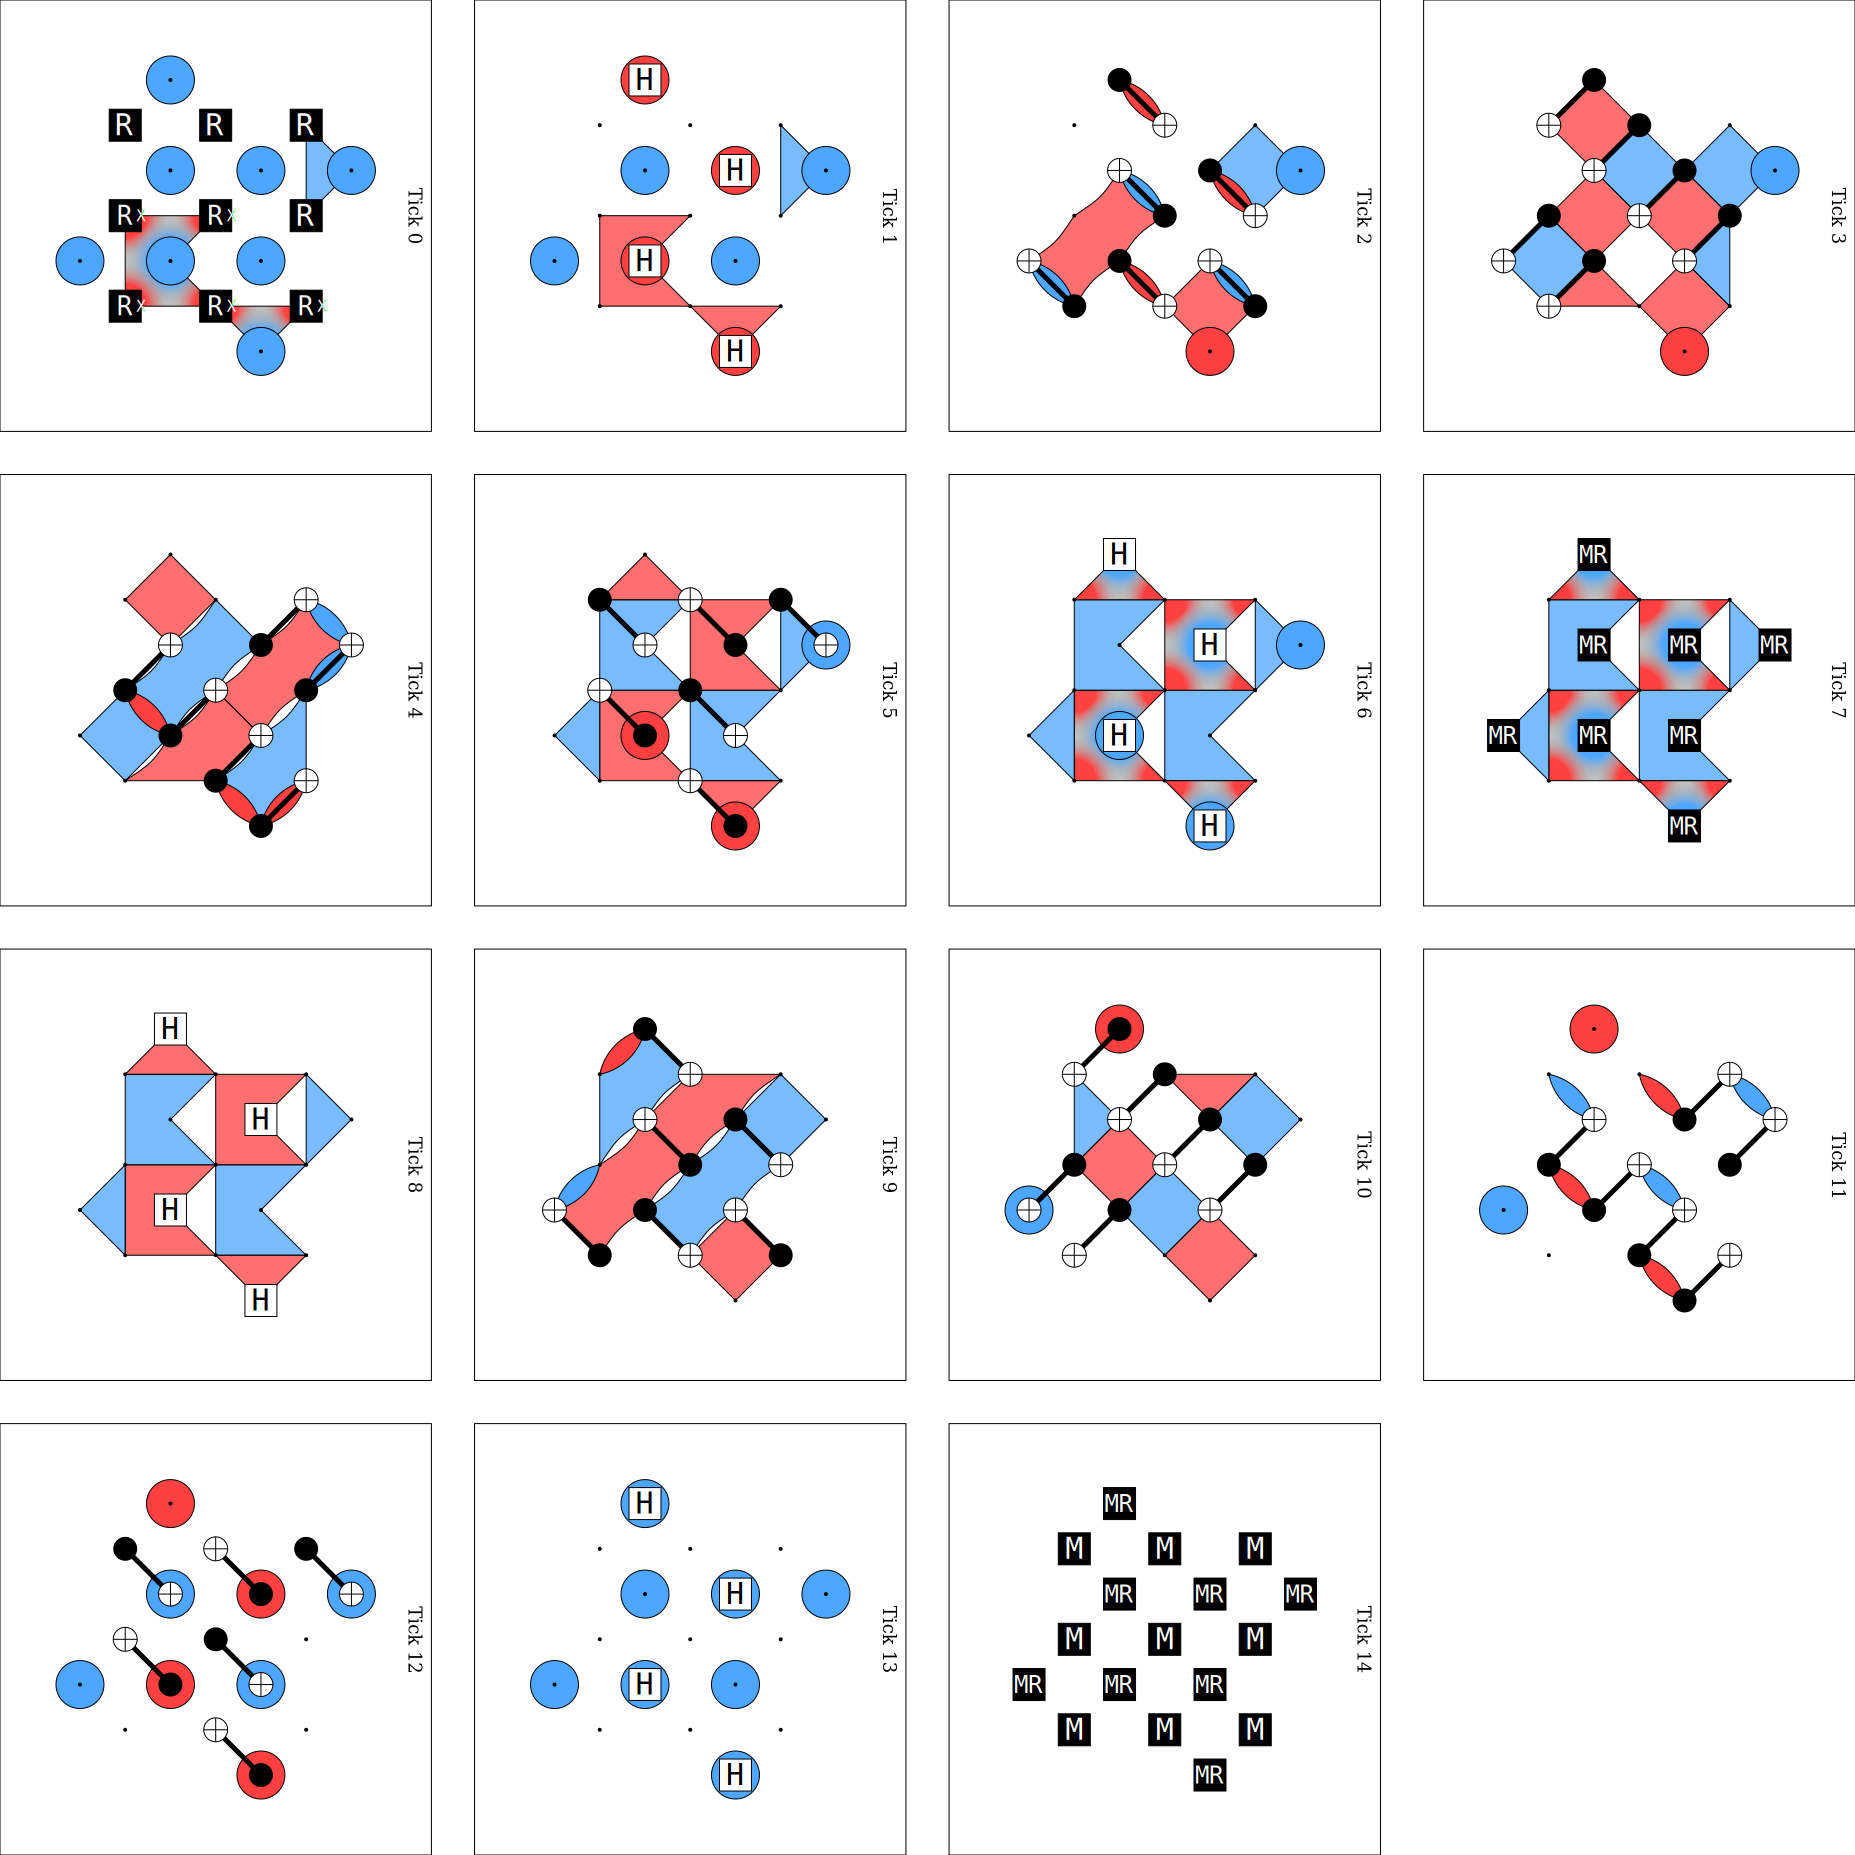

In [3]:
d = 3
rounds = 2
noise_profile = [0, 1e-3, 0, 0]
corner_inject_Z = circuit_corner_injection(d, rounds, noise_profile, "Z")
corner_inject_X = circuit_corner_injection(d, rounds, noise_profile, "X")
corner_inject_Z.without_noise().diagram("detslice-with-ops-svg")

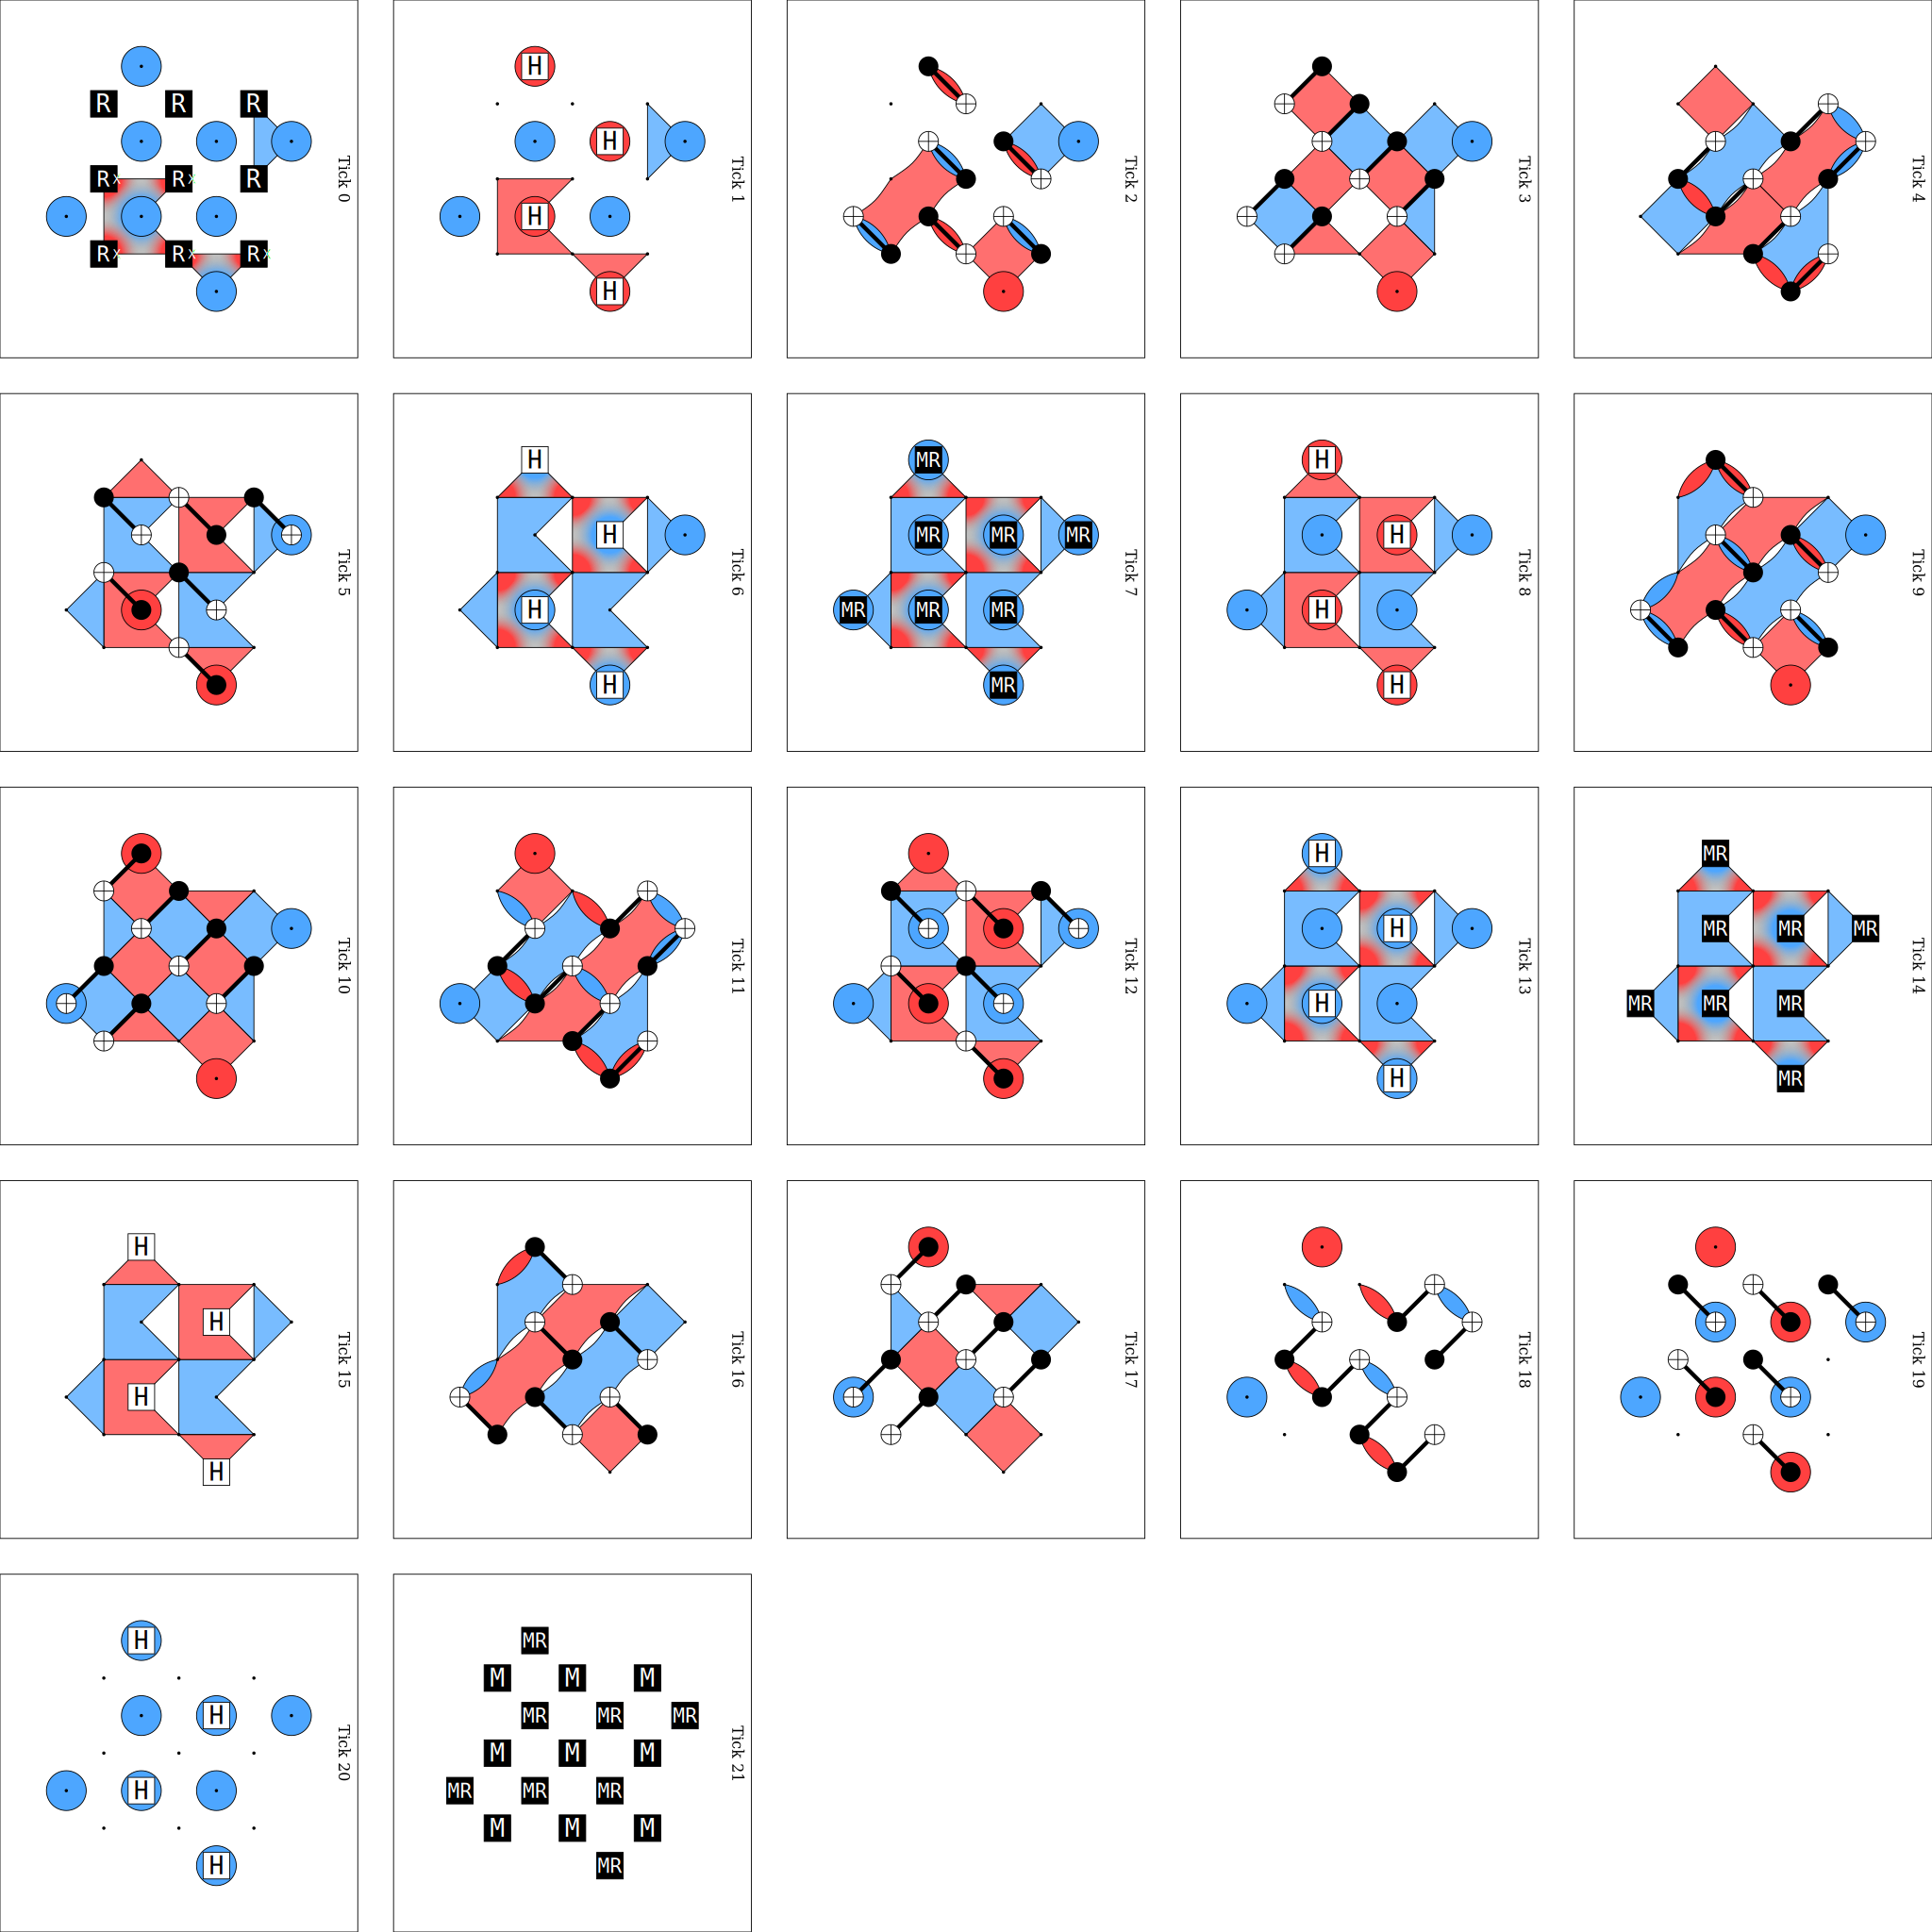

In [4]:
d = 3
rounds = 3
noise_profile = [0, 1e-3, 0, 0]
corner_inject_Z3r = circuit_corner_injection(d, rounds, noise_profile, "Z")
corner_inject_X3r = circuit_corner_injection(d, rounds, noise_profile, "X")
corner_inject_Z3r.without_noise().diagram("detslice-with-ops-svg")

We can see that in TICK 1, the three stabilizers are already formed. In TICK 8, after the first round SM, the system becomes a surface code.  
Next, we do sampling.

In [5]:
def LER_postselect(samples: NDArray[np.bool_]) -> list[float]:
    # Assume one observable at the end
    postselected = [s for s in samples if sum(s[:-1]) == 0]
    N = len(postselected)
    n = sum(s[-1] for s in postselected)

    # Logical error rate with postselection
    if N > 0:
        ler_post = n / N

    # Logical error rate without post-selection
    n_total = len(samples)
    n_obs = sum(s[-1] for s in samples)
    ler_no_post = n_obs / n_total

    postselected_rate = N/n_total
    
    return ler_post, ler_no_post, postselected_rate

In [6]:
num_shots = 1000000
samples_Z = corner_inject_Z.compile_detector_sampler().sample(num_shots, append_observables=True)
print("Inject state: Z")
LER_post, LER_no_post, postselected_rate = LER_postselect(samples_Z)
print(f"LER_post: {LER_post}, LER_no_post: {LER_no_post}, Post-selection Rate: {postselected_rate}")
samples_X = corner_inject_X.compile_detector_sampler().sample(num_shots, append_observables=True)
print("Inject state: X")
LER_post, LER_no_post, postselected_rate = LER_postselect(samples_X)
print(f"LER_post: {LER_post}, LER_no_post: {LER_no_post}, Post-selection Rate: {postselected_rate}")

Inject state: Z
LER_post: 0.0017637142824459473, LER_no_post: 0.007536, Post-selection Rate: 0.961607
Inject state: X
LER_post: 0.00117472287455727, LER_no_post: 0.007348, Post-selection Rate: 0.961929


Try a larger distance d = 5.

In [7]:
def LER_QEC(circuit: stim.Circuit, samples: NDArray[np.bool_]) -> float:
    
    detection_events = samples[:,:-1]
    observable_flips = samples[:,-1:]
    
    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = np.sum(predictions[:, 0] != observable_flips[:, 0])
    
    return num_errors/len(samples)

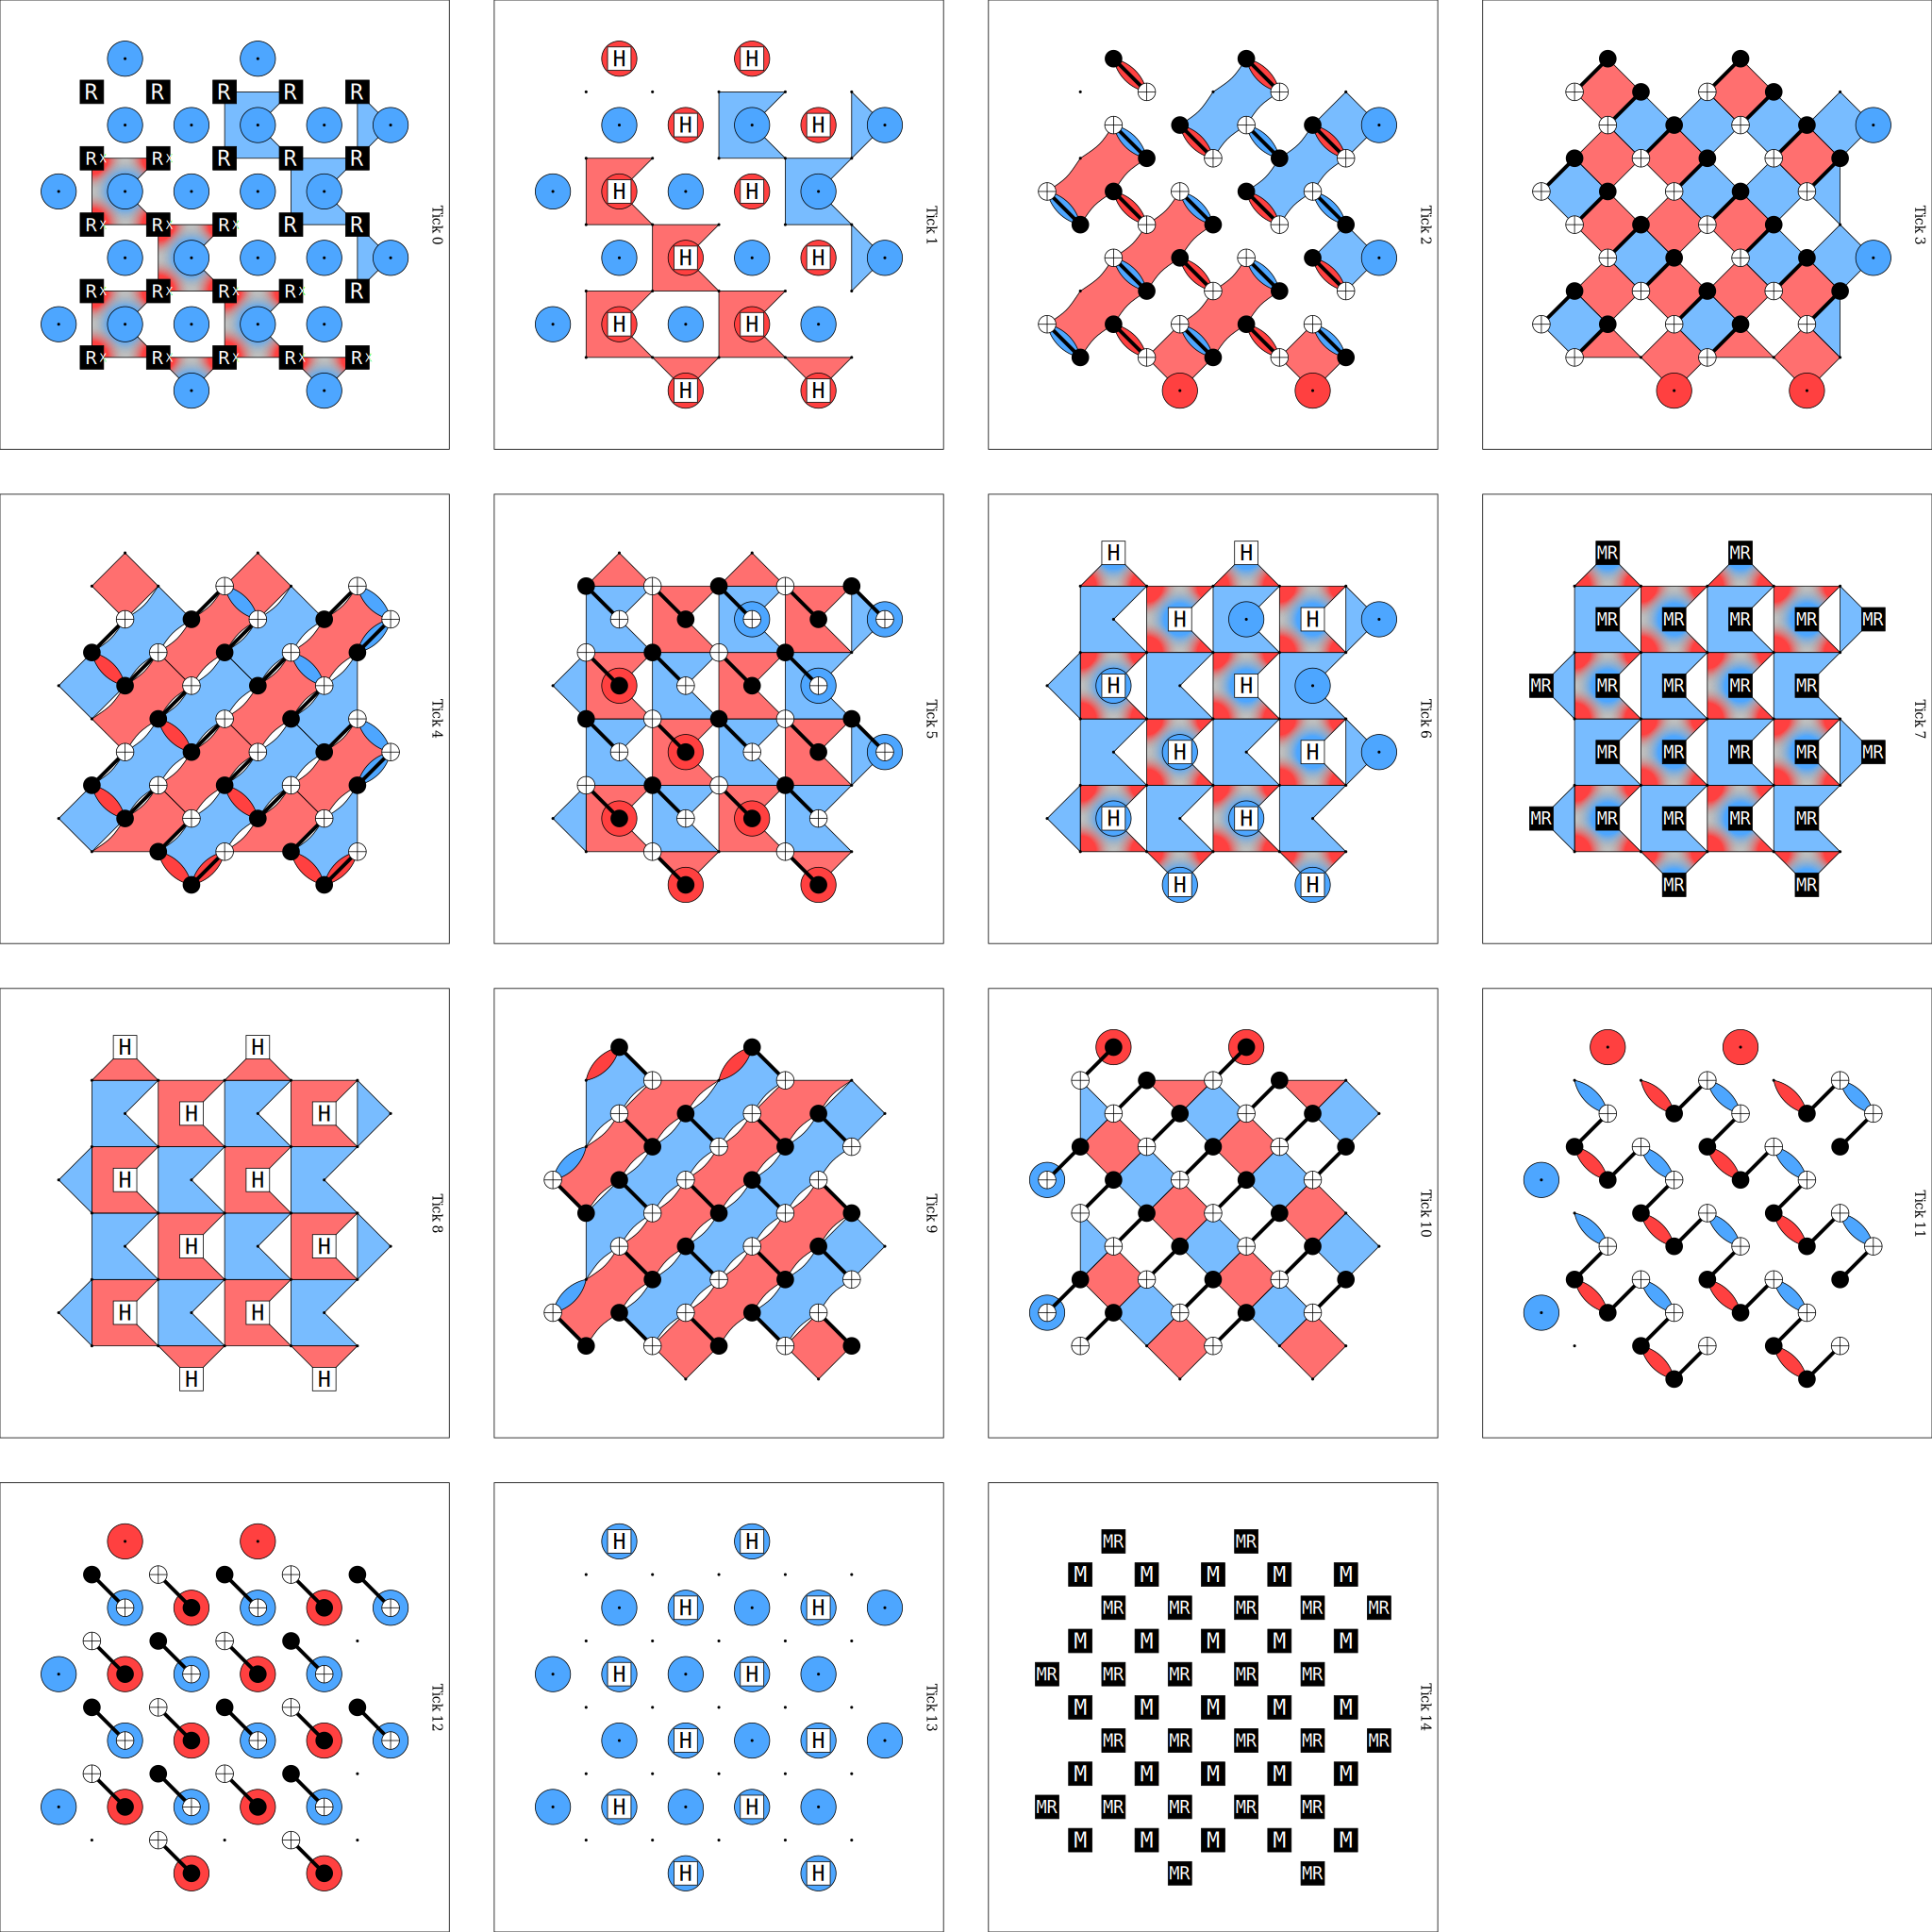

In [8]:
d = 5
noise_profile = [0, 1e-3, 0, 0]
corner_inject_Z5 = circuit_corner_injection(d, 2, noise_profile, "Z")
corner_inject_X5 = circuit_corner_injection(d, 2, noise_profile, "X")
corner_inject_Z5.without_noise().diagram("detslice-with-ops-svg")

In [9]:
num_shots = 1000000
samples_Z5 = corner_inject_Z5.compile_detector_sampler().sample(num_shots, append_observables=True)
print("Inject state: Z")
LER_post, LER_no_post, postselected_rate = LER_postselect(samples_Z5)
print(f"LER_post: {LER_post}, LER_no_post: {LER_no_post}, Post-selection Rate: {postselected_rate}")
samples_X5 = corner_inject_X5.compile_detector_sampler().sample(num_shots, append_observables=True)
print("Inject state: X")
LER_post, LER_no_post, postselected_rate = LER_postselect(samples_X5)
print(f"LER_post: {LER_post}, LER_no_post: {LER_no_post}, Post-selection Rate: {postselected_rate}")

Inject state: Z
LER_post: 0.002509680113015677, LER_no_post: 0.013674, Post-selection Rate: 0.874215
Inject state: X
LER_post: 0.0018770761079438868, LER_no_post: 0.013544, Post-selection Rate: 0.874232


In the following, we try a few other experiments.  

(1) Varying code distance.  
(2) Varying 2Q gate error.  
(3) Varying postselection rounds.  
(4) Compare with error correction.  
(4) Middle injection.

In [10]:
d_list = [3, 5, 7]
# p2_list = [1e-4, 5e-4, 8e-4, 1e-3, 2e-3, 5e-3] # List for complete experiment
p2_list = [1e-4, 1e-3] # use a small list for test
r_list = [2, 3]
# num_samples = 1000000 # complete experiment
num_samples = 1000

def convert_to_per_round(total_LER: float, rounds: int) -> float:
    return 1 - (1 - total_LER)**(1/rounds)


records = []

for d, p2, r, inject in product(d_list, p2_list, r_list, ["Z", "X"]):
    noise_profile = [0, p2, 0, 0]
    corner_inject = circuit_corner_injection(d, r, noise_profile, inject)
    samples = corner_inject.compile_detector_sampler().sample(num_samples, append_observables=True)
    ler_post, ler_no_post, post_rate = LER_postselect(samples)
    ler_post_pr = convert_to_per_round(ler_post, r)
    ler_no_post_pr = convert_to_per_round(ler_no_post, r)
    ler_qec = LER_QEC(corner_inject, samples)
    ler_qec_pr = convert_to_per_round(ler_qec, r)

    records.extend(
        [{"distance": d, "p2": p2, "rounds": r, "LER_type": "post", "inject_state": inject, "LER": ler_post_pr, "post_rate": post_rate},
        {"distance": d, "p2": p2, "rounds": r, "LER_type": "no_post", "inject_state": inject, "LER": ler_no_post_pr, "post_rate": post_rate},
        {"distance": d, "p2": p2, "rounds": r, "LER_type": "qec", "inject_state": inject, "LER": ler_qec_pr, "post_rate": post_rate}]
    )
    
df = pd.DataFrame(records)
# df.to_csv("injection_experiment_results.csv", index=False) # If you wanna save the experiment data to csv


In [11]:
# Take average over "Z" and "X" state injection
df_avg = df.groupby(["distance", "p2", "rounds", "LER_type"]).agg({
    "LER": "mean",
    "post_rate": "mean" 
}).reset_index()

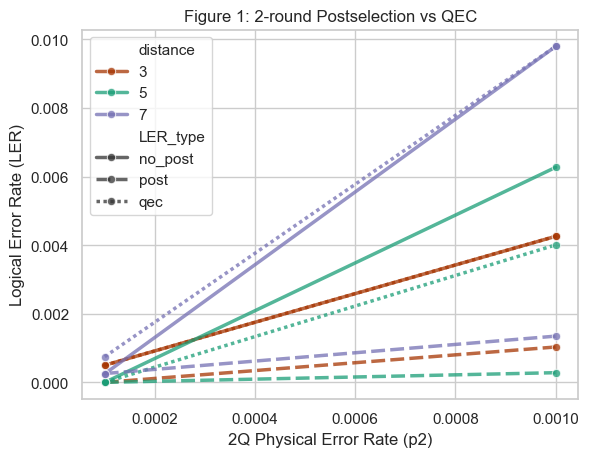

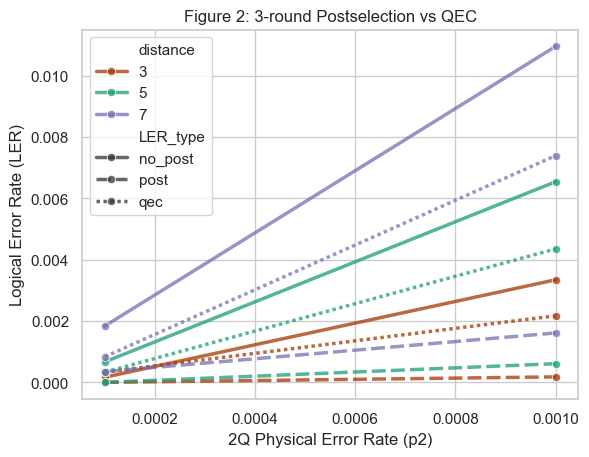

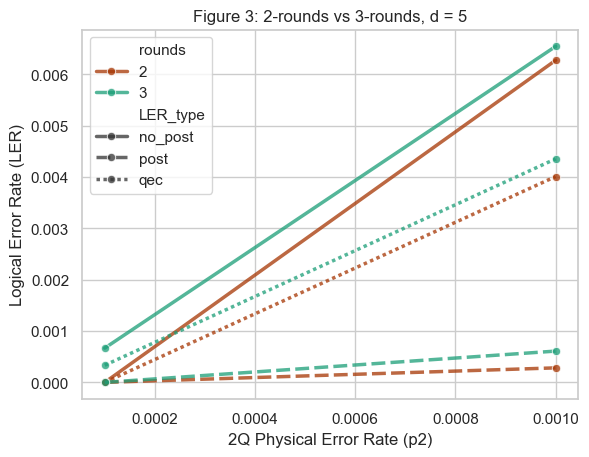

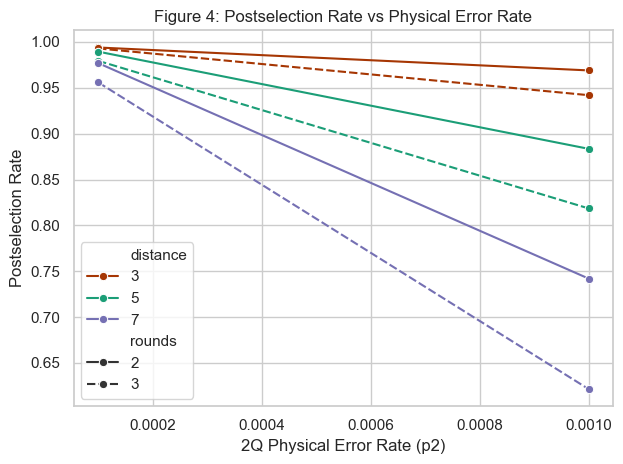

In [12]:
sns.set_theme(style="whitegrid", context="notebook")

palette_distance = {
    3: "#a63603",  # dark orange-brown
    5: "#1b9e77",  # strong green
    7: "#7570b3",  # medium blue
}

palette_rounds = {
    2: "#a63603",  # dark orange-brown
    3: "#1b9e77",  # strong green
}
## Figure 1: 2-round Postselection vs QEC
fig1, ax1 = plt.subplots()
sns.lineplot(
    data=df_avg[df_avg.rounds == 2],
    x="p2", y="LER",
    hue="distance", style="LER_type",
    linewidth=2.5, alpha=0.75,
    palette=palette_distance, ax=ax1, marker= 'o'
)
# ax1.set_xscale("log")
# ax1.set_yscale("log") # if you want a log-log plot
ax1.set_title("Figure 1: 2-round Postselection vs QEC")
ax1.set_xlabel("2Q Physical Error Rate (p2)")
ax1.set_ylabel("Logical Error Rate (LER)")
ax1.grid(True)

## Figure 2: 3-round Postselection vs QEC
fig2, ax2 = plt.subplots()
sns.lineplot(
    data=df_avg[df_avg.rounds == 3],
    x="p2", y="LER",
    hue="distance", style="LER_type",
    linewidth=2.5, alpha=0.75,
    palette=palette_distance, ax=ax2, marker= 'o'
)
ax2.set_title("Figure 2: 3-round Postselection vs QEC")
ax2.set_xlabel("2Q Physical Error Rate (p2)")
ax2.set_ylabel("Logical Error Rate (LER)")
ax2.grid(True)

## Figure 3: 2,3-round Postselection vs QEC
fig3, ax3 = plt.subplots()
sns.lineplot(
    data=df_avg[df_avg.distance == 5],
    x="p2", y="LER",
    hue="rounds", style="LER_type",
    linewidth=2.5, alpha=0.75,
    palette=palette_rounds, ax=ax3, marker = 'o'
)
ax3.set_title("Figure 3: 2-rounds vs 3-rounds, d = 5")
ax3.set_xlabel("2Q Physical Error Rate (p2)")
ax3.set_ylabel("Logical Error Rate (LER)")
ax3.grid(True)

## Figure 4: Postselection Rate
fig4, ax4 = plt.subplots()
sns.lineplot(
    data=df_avg[df_avg.LER_type == "post"], 
    x="p2", y="post_rate", 
    hue="distance", style="rounds",
    palette=palette_distance,
    ax=ax4, marker="o")
ax4.set_title("Figure 4: Postselection Rate vs Physical Error Rate")
ax4.set_xlabel("2Q Physical Error Rate (p2)")
ax4.set_ylabel("Postselection Rate")
ax4.grid(True)

plt.tight_layout()
plt.show()

1.2 Center Injection  
This was originally left as an exercise. Thanks to Sharanya Prabhu for completing this during summer 2025 as an intern.


In [13]:
def circuit_middle_injection(d: int, rounds: int, noise_profile: list[float], inject_state: str) -> stim.Circuit:

    p1, p2, p_M, p_R = noise_profile
    surface_code = sf.RotateSurfaceCode(d)
    full_circuit = stim.Circuit()

    coord_to_index = surface_code.coord_to_index
    data_coords = surface_code.data_coords
    ancilla_coords = surface_code.ancilla_coords

    # Annotate qubits
    for (x, y), index in coord_to_index.items():
        full_circuit.append("QUBIT_COORDS", [index], [x, y])

    def logical_to_physical(coord):
        x, y = coord
        return (2 * (x - 1) + 1, 2 * (y - 1) + 1)
    
    mid = d // 2 + 1
    injection_coord_logical = (mid, mid)

    zero_coords_logical = []
    plus_coords_logical = []

    for x in range(1, d + 1):
        for y in range(1, d + 1):
            if (x, y) == injection_coord_logical:
                continue
            elif (x < y and x + y <= d + 1) or (x > y and x + y >= d + 1):
                zero_coords_logical.append((x, y))
            else:
                plus_coords_logical.append((x, y))


    zero_coords = [logical_to_physical(c) for c in zero_coords_logical if logical_to_physical(c) in coord_to_index]
    plus_coords = [logical_to_physical(c) for c in plus_coords_logical if logical_to_physical(c) in coord_to_index]
    injection_coord = logical_to_physical(injection_coord_logical)

    if injection_coord not in coord_to_index:
        raise ValueError(f"Injection coordinate {injection_coord} not in layout")

    inject_index = coord_to_index[injection_coord]

    # Initialize data qubits
    full_circuit.append_operation("R", [coord_to_index[c] for c in zero_coords])
    full_circuit.append_operation("X_ERROR", [coord_to_index[c] for c in zero_coords], p_R)

    full_circuit.append_operation("RX", [coord_to_index[c] for c in plus_coords])
    full_circuit.append_operation("Z_ERROR", [coord_to_index[c] for c in plus_coords], p_R)

    if inject_state == "Z":
        full_circuit.append_operation("R", [inject_index])
        full_circuit.append_operation("X_ERROR", [inject_index], p_R)
    elif inject_state == "X":
        full_circuit.append_operation("RX", [inject_index])
        full_circuit.append_operation("Z_ERROR", [inject_index], p_R)
    else:
        raise ValueError("inject_state must be 'Z' or 'X'")

    full_circuit.append("TICK")

    # First round of stabilizer measurement
    full_circuit += surface_code.build_standard_sm_round(noise_profile)

    detectors_physical = []
    for x in range(1, d + 2):
        for y in range(1, d + 2):
            is_z_stab = (x + y) % 2 == 0
            is_x_stab = (x + y) % 2 == 1

            keep = False
            if is_z_stab:
                keep = (x < y and x + y < d + 2) or (x > y and x + y > d + 2)
            if is_x_stab:
                keep = (x < y and x + y > d + 2) or (x > y and x + y < d + 2)

            if keep:
                px, py = 2 * (x - 1), 2 * (y - 1)
                if (px, py) in ancilla_coords:
                    detectors_physical.append((px, py))

    for anc in detectors_physical:
        if anc not in ancilla_coords:
            continue
        try:
            k = len(ancilla_coords) - 1 - ancilla_coords.index(anc)
        except ValueError:
            continue
        full_circuit.append_operation("DETECTOR", [stim.target_rec(-k - 1)], list(anc) + [0])

    # Repeated SM rounds
    repeat_circuit = stim.Circuit()
    repeat_circuit.append("TICK")
    repeat_circuit += surface_code.build_standard_sm_round(noise_profile)
    repeat_circuit.append_operation("SHIFT_COORDS", [], [0, 0, 1])

    for k, anc in enumerate(reversed(ancilla_coords)):
        prev = -k - 1 - len(ancilla_coords)
        repeat_circuit.append_operation("DETECTOR", [stim.target_rec(-k - 1), stim.target_rec(prev)], list(anc) + [0])

    full_circuit += repeat_circuit * (rounds - 1)

    # Final data measurement
    data_indices = [coord_to_index[c] for c in data_coords]
    if inject_state == "X":
        full_circuit.append_operation("H", data_indices)
    full_circuit.append_operation("M", data_indices)

    # Logical observables
    if inject_state == "X":
        logical_logical = [(d//2 + 1, y) for y in range(1, d + 1)]  # Z observable (row)
    elif inject_state == "Z":
        logical_logical = [(x, d//2 + 1) for x in range(1, d + 1)]  # X observable (column)
    else:
        raise ValueError("inject_state must be 'Z' or 'X'")

    logical_physical = [logical_to_physical(c) for c in logical_logical if logical_to_physical(c) in coord_to_index]
    logical_targets = [
        stim.target_rec(-1 - data_coords[::-1].index(c))
        for c in logical_physical
    ]
    full_circuit.append("OBSERVABLE_INCLUDE", logical_targets, 0)

    return full_circuit


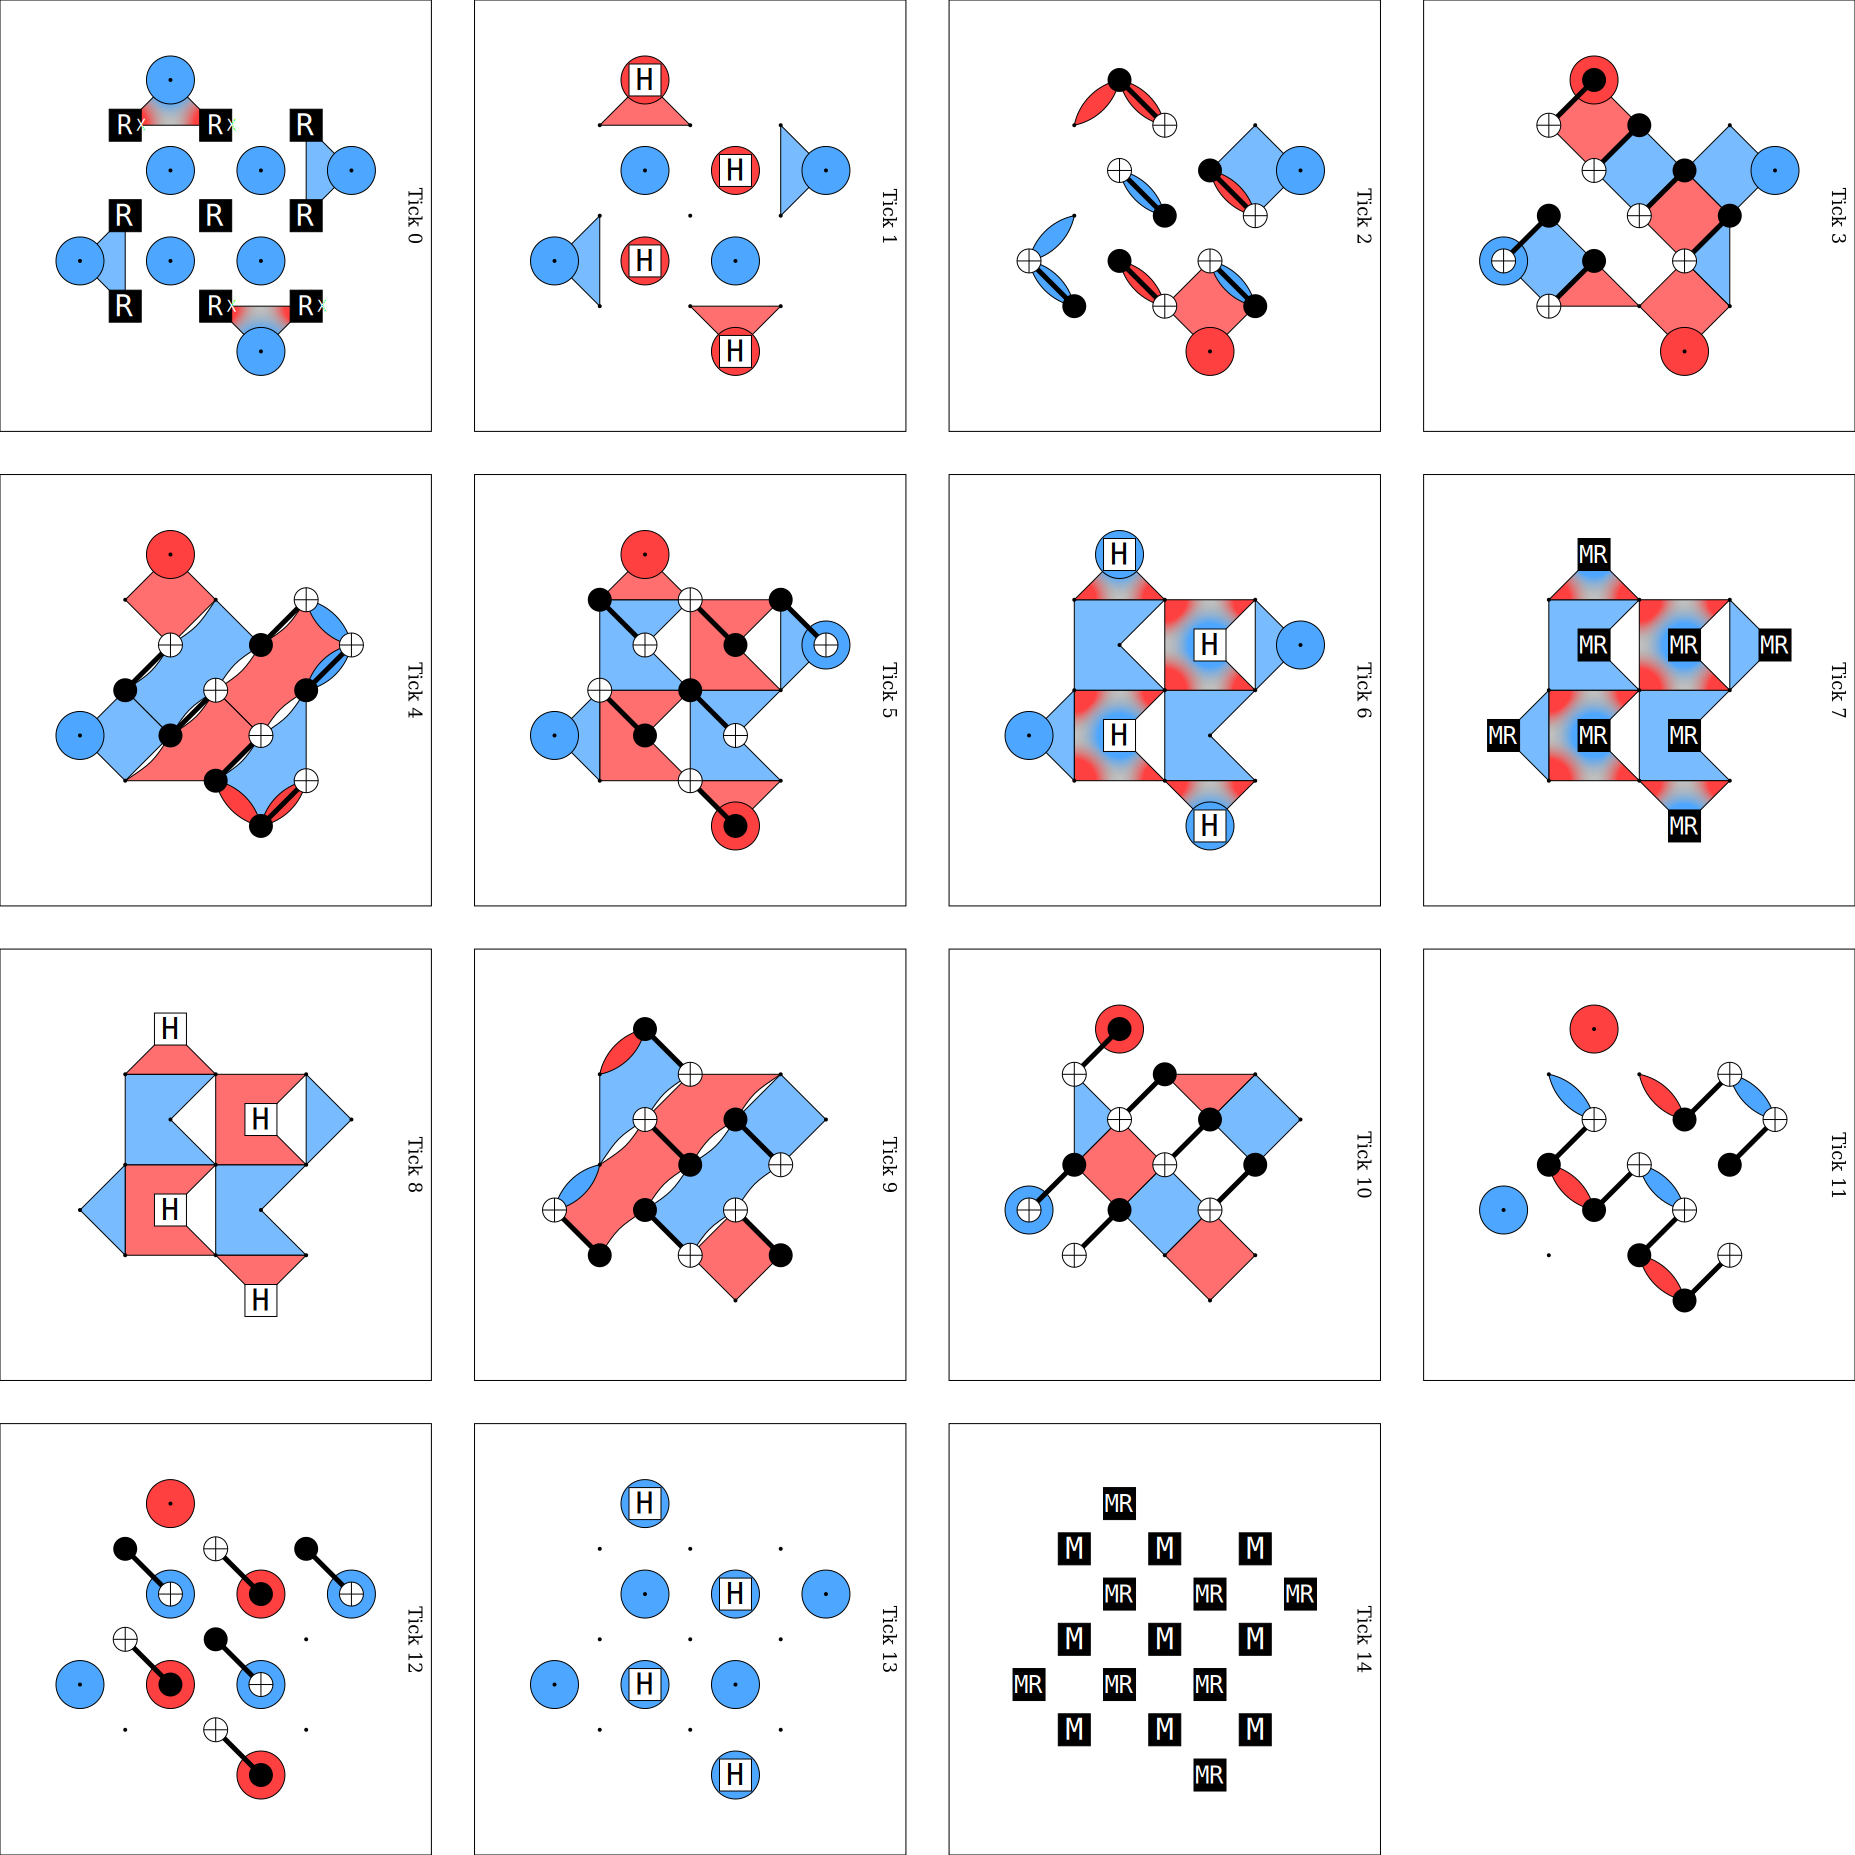

In [14]:
d = 3  
rounds = 2
noise_profile = [0, 1e-3, 0, 0]  # [p1, p2, p_M, p_R]

middle_inject_Z3 = circuit_middle_injection(d, rounds, noise_profile, "Z")
middle_inject_X3 = circuit_middle_injection(d, rounds, noise_profile, "X")

# Visualize noiseless circuit detector slice
middle_inject_Z3.without_noise().diagram("detslice-with-ops-svg")

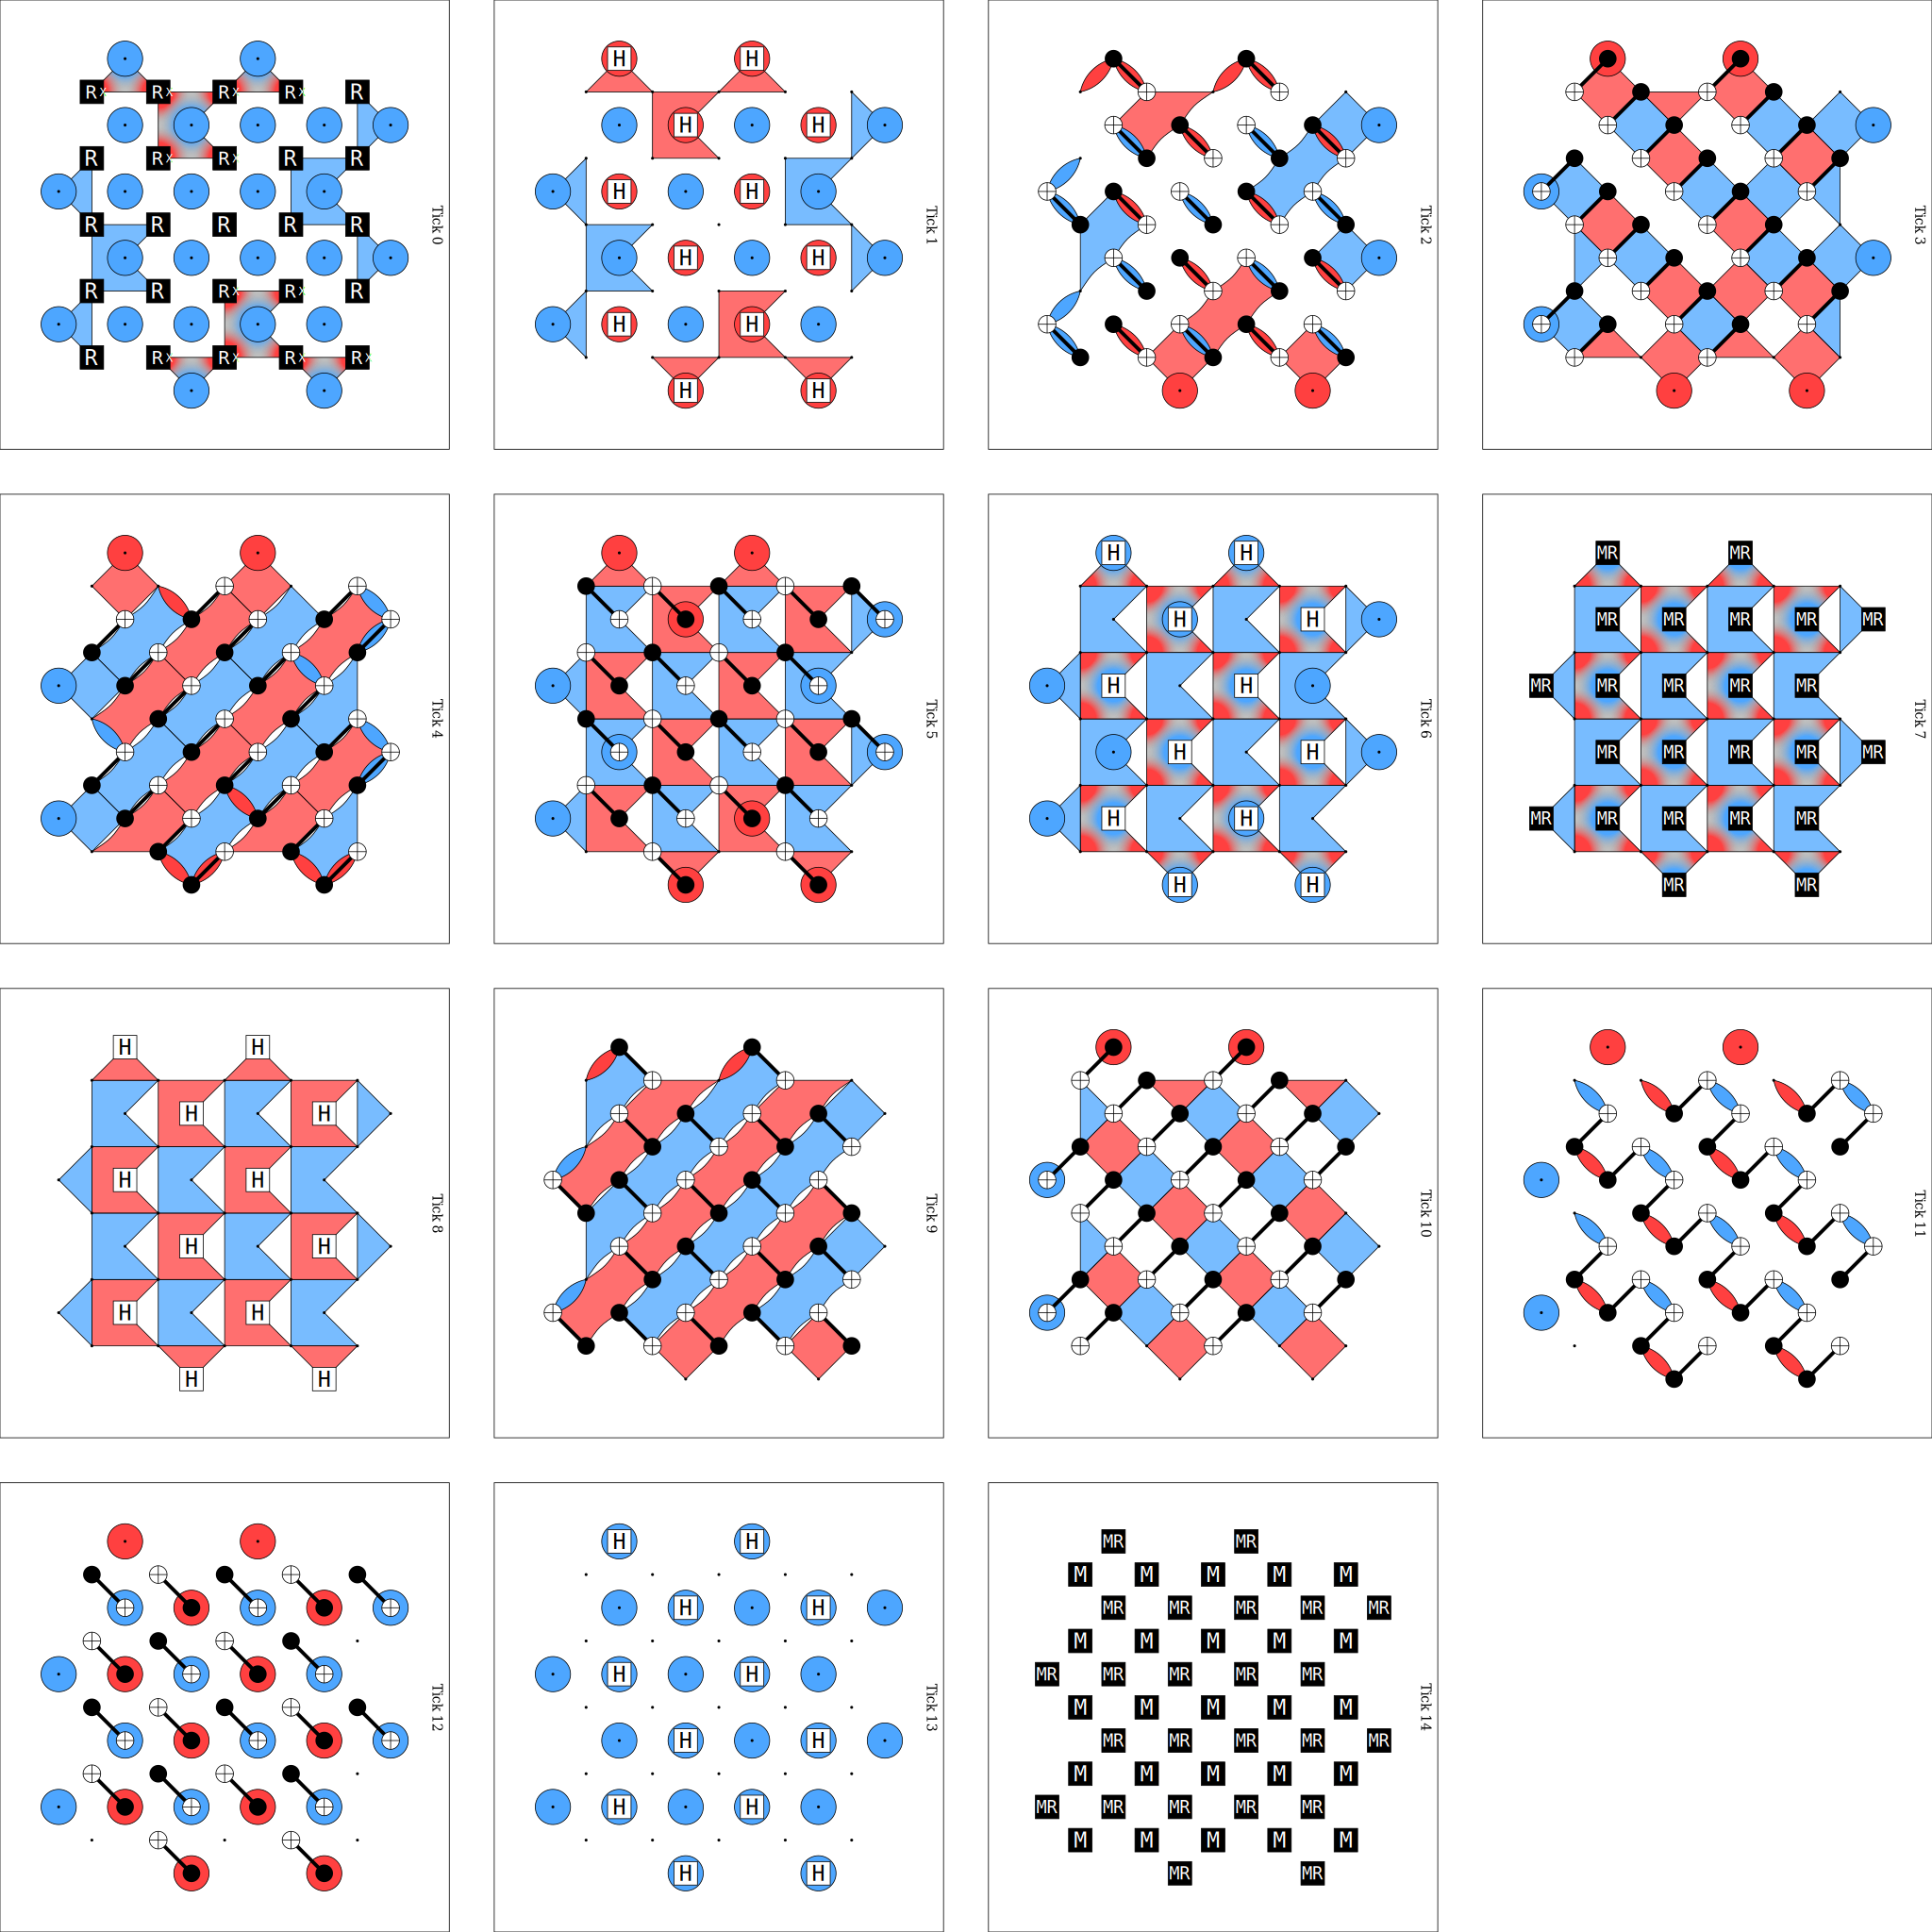

In [15]:
d = 5  
rounds = 2
noise_profile = [0, 1e-3, 0, 0]  # [p1, p2, p_M, p_R]

middle_inject_Z5 = circuit_middle_injection(d, rounds, noise_profile, "Z")
middle_inject_X5 = circuit_middle_injection(d, rounds, noise_profile, "X")

# Visualize noiseless circuit detector slice
middle_inject_Z5.without_noise().diagram("detslice-with-ops-svg")

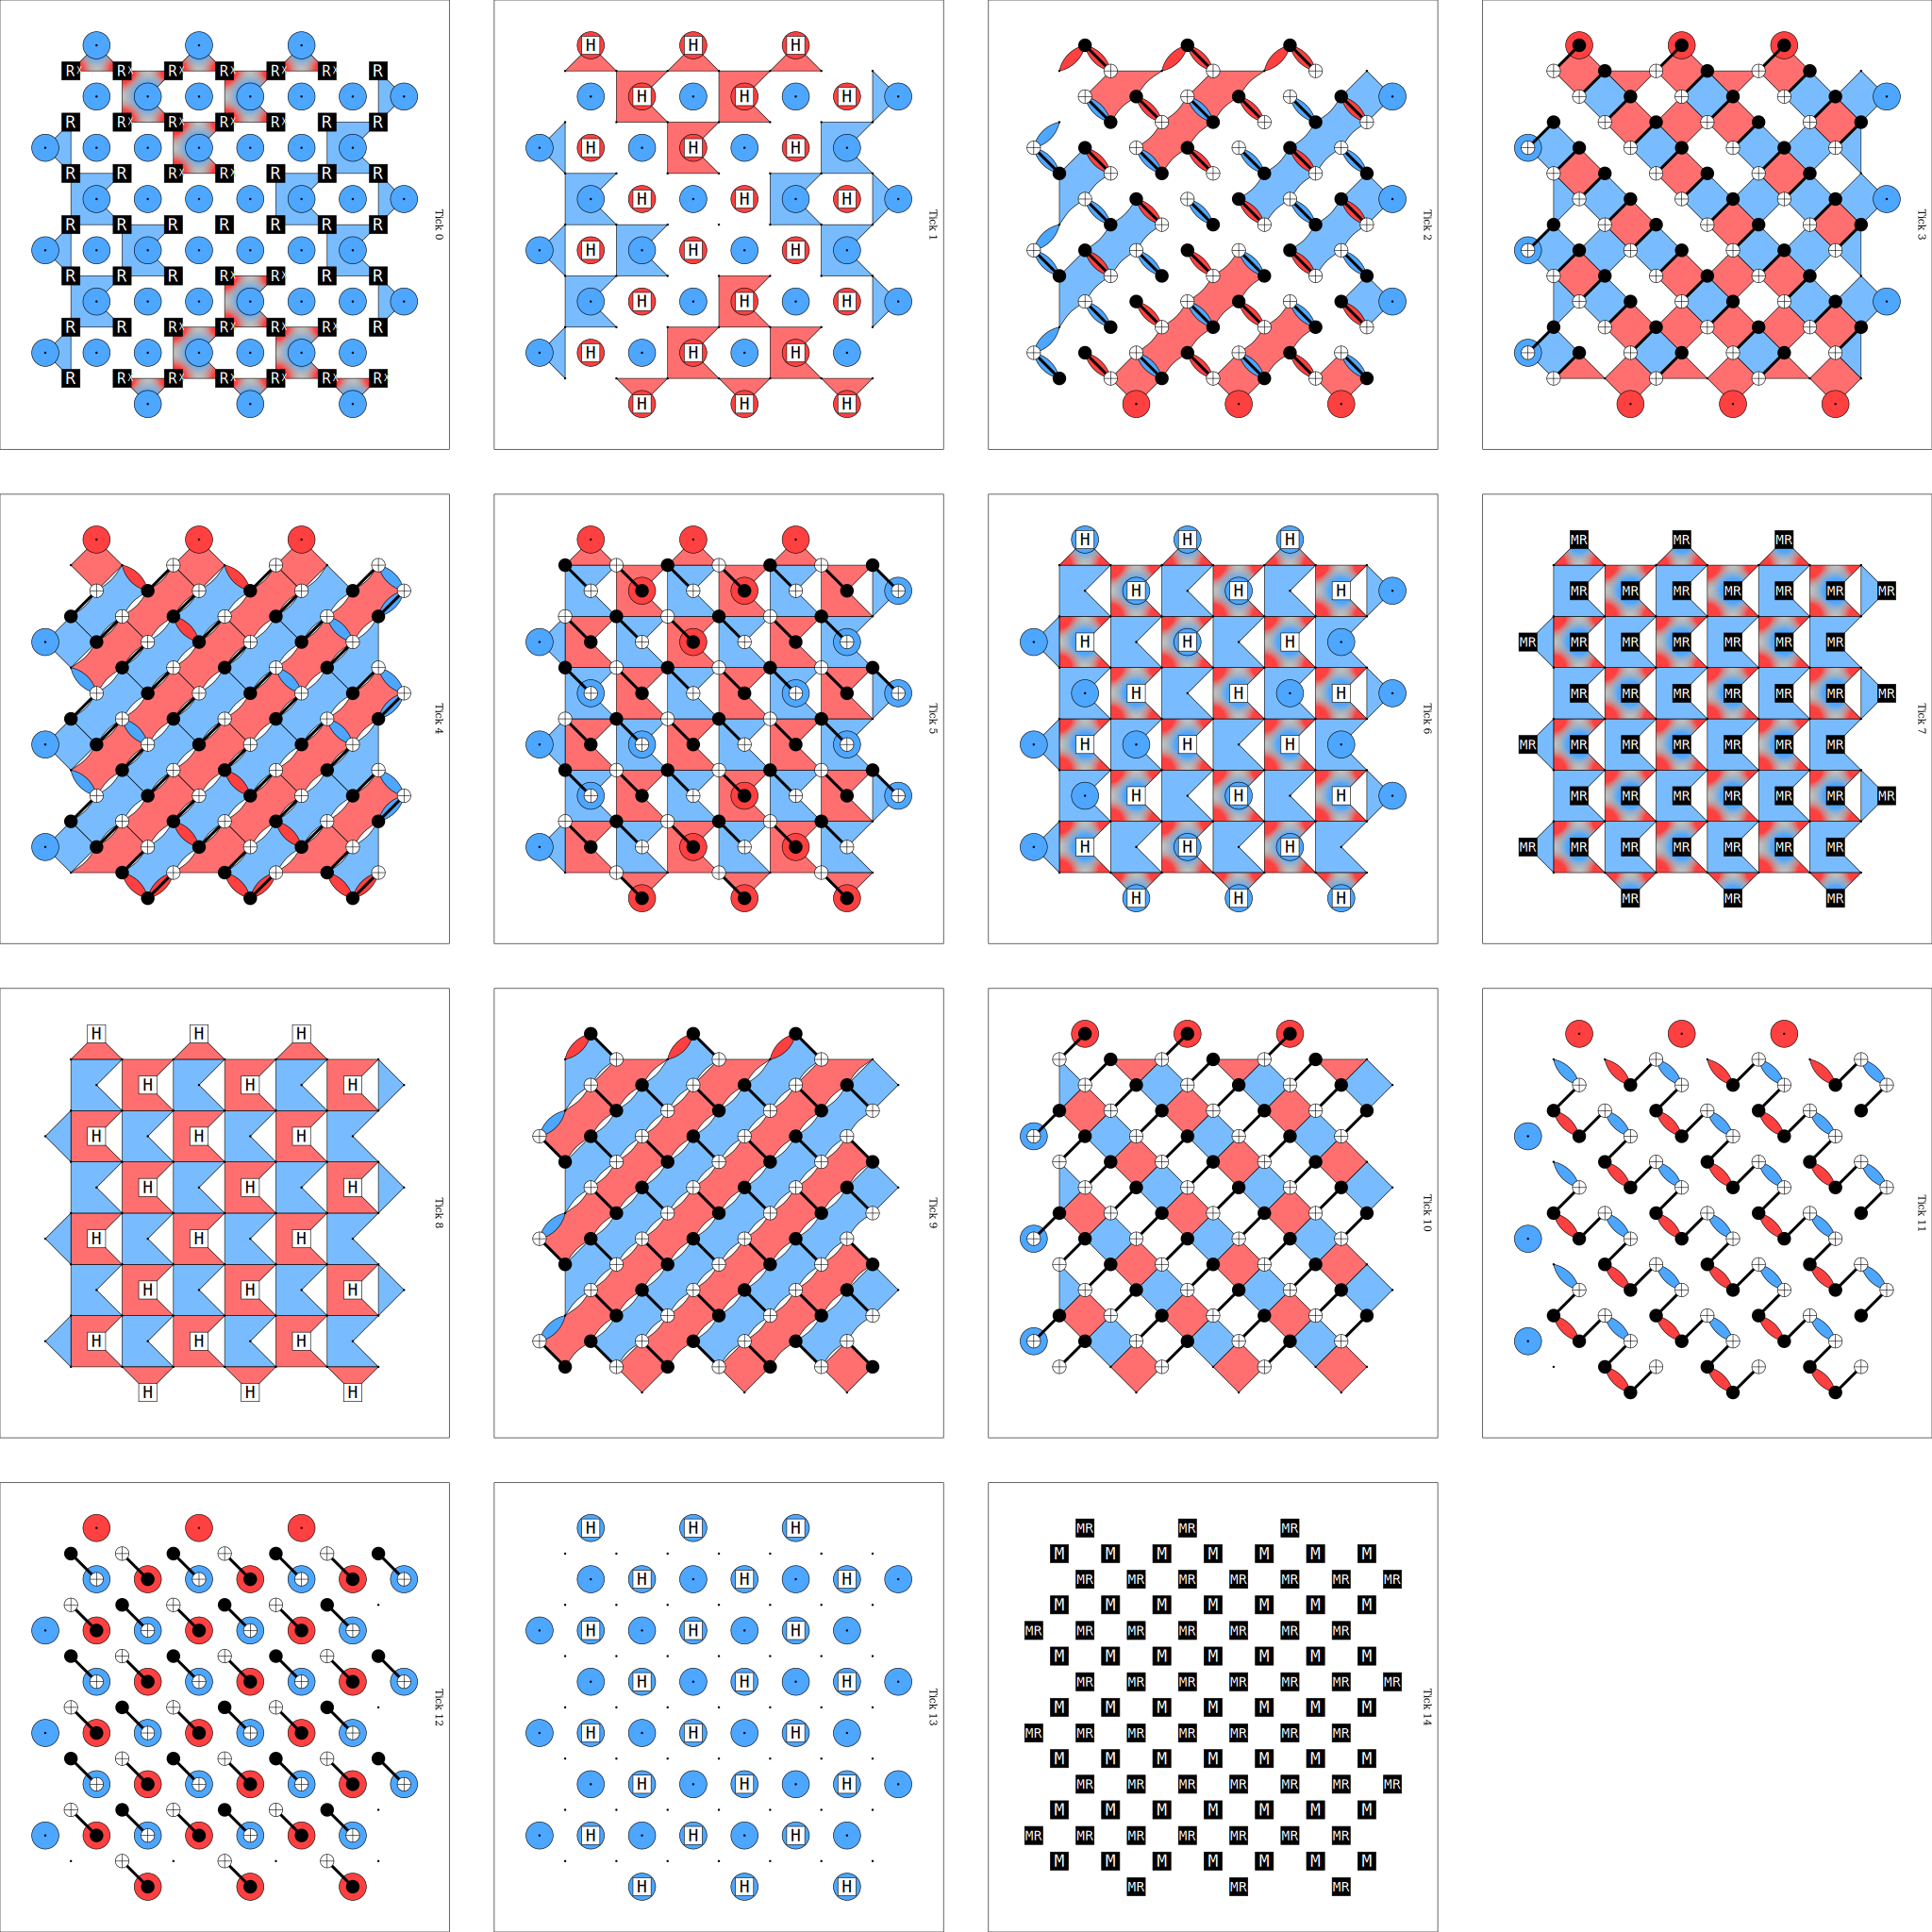

In [16]:
d = 7  
rounds = 2
noise_profile = [0, 1e-3, 0, 0]  # [p1, p2, p_M, p_R]

middle_inject_Z7 = circuit_middle_injection(d, rounds, noise_profile, "Z")
middle_inject_X7 = circuit_middle_injection(d, rounds, noise_profile, "X")

# Visualize noiseless circuit detector slice
middle_inject_Z7.without_noise().diagram("detslice-with-ops-svg")

In [17]:
num_shots = 1000000
samples_Z5 = middle_inject_Z5.compile_detector_sampler().sample(num_shots, append_observables=True)
print("Inject state: Z")
LER_post, LER_no_post, postselected_rate = LER_postselect(samples_Z5)
print(f"LER_post: {LER_post}, LER_no_post: {LER_no_post}, Post-selection Rate: {postselected_rate}")
samples_X5 = middle_inject_X5.compile_detector_sampler().sample(num_shots, append_observables=True)
print("Inject state: X")
LER_post, LER_no_post, postselected_rate = LER_postselect(samples_X5)
print(f"LER_post: {LER_post}, LER_no_post: {LER_no_post}, Post-selection Rate: {postselected_rate}")

Inject state: Z
LER_post: 0.002207576145380087, LER_no_post: 0.018747, Post-selection Rate: 0.875168
Inject state: X
LER_post: 0.0023820077869376862, LER_no_post: 0.018704, Post-selection Rate: 0.875312


The LER is around the same level as the corner injection. However, we some how see a more "balanced" LER between Z and X memory experiment.

### 2. Enlarging Protocol
The injection protocol with QEC is exactly the enlarging protcol. The general enlarging process from distance $d_1$ surface code to distance $d_2$ surface code ($d_1 < d_2$) is left as an exercise.

### 3. Shrinking Protocol  
Shrinking is the reverse process of enlarging. We only present the "shrink to corner" protocol, which is the opposite of the corner injection protocol. The "shrink to middle" protocol will be left as an exercise.  
We will use noise-free circuit to generate a perfect surface code patch, and then perform the shrinking process with noise inserted.

In [18]:
def circuit_corner_shrink(d: int, noise_profile: list[float], inject_state: str) -> stim.Circuit:
    
    p1, p2, p_M, p_R = noise_profile

    surface_code = sf.RotateSurfaceCode(d)

    full_circuit = stim.Circuit()

    coord_to_index = surface_code.coord_to_index
    data_coords = surface_code.data_coords
    ancilla_coords = surface_code.ancilla_coords

    # Add QUBIT_COORDS annotations
    for (x, y), index in coord_to_index.items():
        full_circuit.append('QUBIT_COORDS', [index], [x, y])
    
    # First prepare logical |0> or |+> state
    # Initialization pattern
    lower_diagonal_data = []
    upper_diagonal_data = []

    for x, y in data_coords:
        if (x, y) == (1, 1):
            continue  # Corner qubit
        if y >= x:
            lower_diagonal_data.append((x, y))
        else:
            upper_diagonal_data.append((x, y))

    lower_indices = [coord_to_index[q] for q in lower_diagonal_data]
    upper_indices = [coord_to_index[q] for q in upper_diagonal_data]
    data_indices = [coord_to_index[q] for q in data_coords]
    ancilla_indices = [coord_to_index[q] for q in ancilla_coords]

    full_circuit.append_operation("RX", lower_indices)
    full_circuit.append_operation("R", upper_indices)
    full_circuit.append_operation("R", ancilla_indices)

    shrink_qubits = lower_diagonal_data + upper_diagonal_data

    # Injected simulatable state into the corner qubit (|0> or |+>)
    corner = (1, 1)
    corner_index = coord_to_index[corner]
    if inject_state == "Z":
        full_circuit.append_operation("R", [corner_index])
    elif inject_state == "X":
        full_circuit.append_operation("RX", [corner_index])
    else:
        raise ValueError("inject_state must be 'Z' or 'X'")
    full_circuit.append("TICK")

    # First round of SM, this should give a perfect surface code
    one_round = surface_code.build_standard_sm_round(noise_profile)
    full_circuit += one_round
    full_circuit = full_circuit.without_noise()

    # # Check if this one round circuit generate a perfect surface code
    # # Final measurement of data qubits in Z or X basis
    # if inject_state == "X":
    #     full_circuit.append_operation("MX", data_indices),
    # else: # if it's "Z"
    #     full_circuit.append_operation("M", data_indices)
    # # logical observables
    # logical_key = 'logical_' + inject_state
    # for l, logical_data in enumerate(getattr(surface_code, logical_key)):
    #     data_indices = [data_coords[::-1].index(data) for data in logical_data]
    #     full_circuit.append_operation("OBSERVABLE_INCLUDE", [stim.target_rec(-k-1) for k in data_indices], l)
    
    # Then shrink to corner with noise inserted
    # Insert depolarizing errors on data qubits
    full_circuit.append_operation("DEPOLARIZE1", data_indices, p1)

    # Final measurement of data qubits with noise inserted
    # Notice that we left the corner qubit unmeasured
    full_circuit.append_operation("Z_ERROR", lower_indices, p_M)
    full_circuit.append_operation("MX", lower_indices)
    full_circuit.append_operation("Z_ERROR", lower_indices, p_R)
    full_circuit.append_operation("X_ERROR", upper_indices, p_M)
    full_circuit.append_operation("M", upper_indices)
    full_circuit.append_operation("X_ERROR", upper_indices, p_R)

    # Now measure the corner qubit, we should not insert error because this step will not be performed
    # in a shrinking protocol; we do this only for implying the logical observable
    if inject_state == "X":
        full_circuit.append_operation("MX", coord_to_index[(1,1)])
    else:
        full_circuit.append_operation("M", coord_to_index[(1,1)])

    # Final detectors for postselction; 
    # the QEC should be performed on the shrinked code patch, but here just a single qubit
    for stab in surface_code.stabilizers:
        # Upper diagonal Z stabilizers
        anc = stab['ancilla']
        if stab['type'] == "Z" and anc[0] > anc[1] or stab['type'] == "X" and anc[0] < anc[1]:
            # ancilla_index = ancilla_coords[::-1].index(anc)
            # # the last -1 excludes the corner qubit
            # anc_rec = stim.target_rec(-ancilla_index - 1 - len(data_coords))
            data_rec_targets = [stim.target_rec(-shrink_qubits[::-1].index(q) - 2) for q in stab['data']]
            full_circuit.append_operation("DETECTOR", data_rec_targets, list(anc) + [0])

    # logical observables
    logical_key = 'logical_' + inject_state
    logical_data = getattr(surface_code, logical_key)[0]
    measured_qubits = shrink_qubits + [corner]
    data_indices = [measured_qubits[::-1].index(data) for data in logical_data]
    full_circuit.append_operation("OBSERVABLE_INCLUDE", [stim.target_rec(-k-1) for k in data_indices], 0)

    return full_circuit

In [19]:
c3 = circuit_corner_shrink(d = 3, noise_profile = [0, 0, 1e-3, 0], inject_state = "Z")
c3

stim.Circuit('''
    QUBIT_COORDS(2, 0) 0
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(3, 1) 2
    QUBIT_COORDS(5, 1) 3
    QUBIT_COORDS(2, 2) 4
    QUBIT_COORDS(4, 2) 5
    QUBIT_COORDS(6, 2) 6
    QUBIT_COORDS(1, 3) 7
    QUBIT_COORDS(3, 3) 8
    QUBIT_COORDS(5, 3) 9
    QUBIT_COORDS(0, 4) 10
    QUBIT_COORDS(2, 4) 11
    QUBIT_COORDS(4, 4) 12
    QUBIT_COORDS(1, 5) 13
    QUBIT_COORDS(3, 5) 14
    QUBIT_COORDS(5, 5) 15
    QUBIT_COORDS(4, 6) 16
    RX 7 8 13 14 15
    R 2 3 9 0 4 5 6 10 11 12 16 1
    TICK
    H 0 5 11 16
    TICK
    CX 0 2 5 9 11 14 8 4 13 10 15 12
    TICK
    CX 0 1 5 8 11 13 2 4 7 10 9 12
    TICK
    CX 5 3 11 8 16 15 7 4 9 6 14 12
    TICK
    CX 5 2 11 7 16 14 1 4 3 6 8 12
    TICK
    H 0 5 11 16
    TICK
    MR 0 4 5 6 10 11 12 16
    DEPOLARIZE1(0) 1 2 3 7 8 9 13 14 15
    Z_ERROR(0.001) 7 8 13 14 15
    MX 7 8 13 14 15
    Z_ERROR(0) 7 8 13 14 15
    X_ERROR(0.001) 2 3 9
    M 2 3 9
    X_ERROR(0) 2 3 9
    M 1
    DETECTOR(6, 2, 0) rec[-3] rec[-2]
    DETE

It's worth mentioning that in the detector construction, there are only data qubits included. It is because (1) we know the measurements on data qubits should add up to 0, because those stabilizers have value 1, implied by the surface code initialization; (2) the ancilla qubit measurement in the final round does not reflect the stabilizer value because there is no CNOT interaction in the shrinking protocol. Therefore, the ancilla qubit should not be included in the detector as in the standard approach in memory experiment.

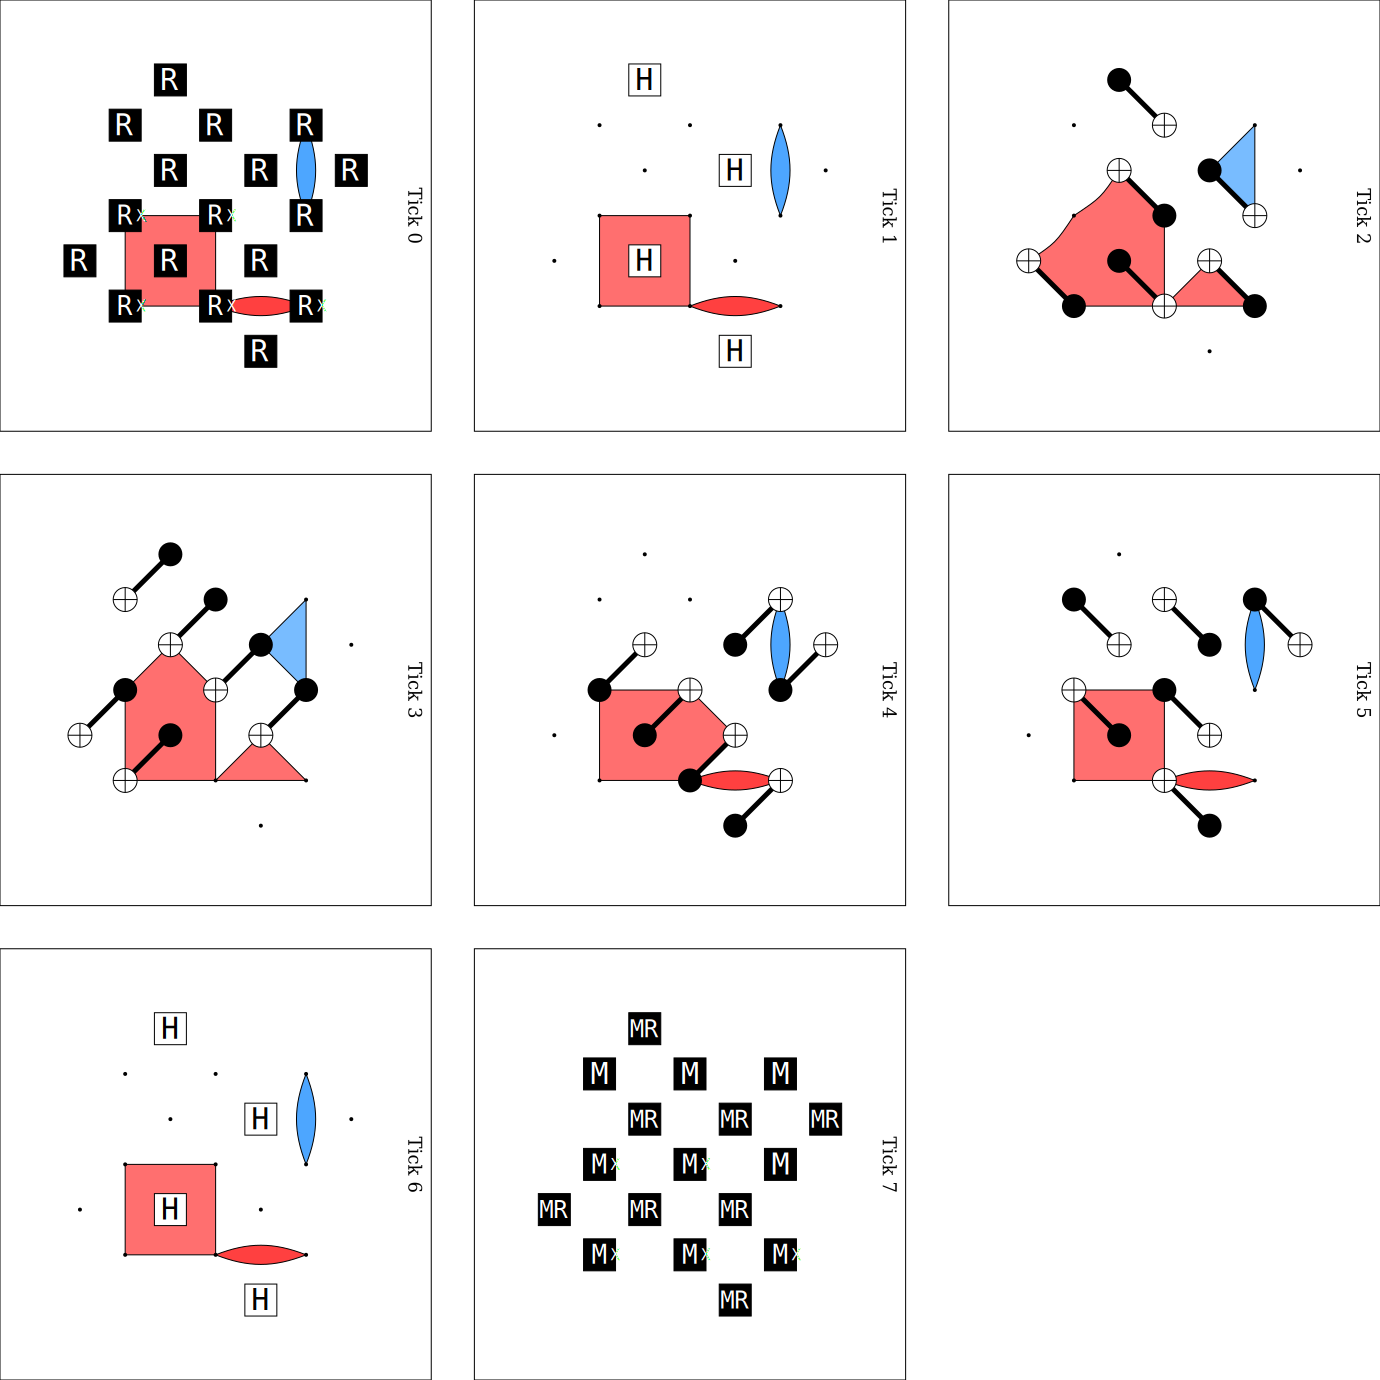

In [20]:
c3.without_noise().diagram("detslice-with-ops-svg")

In [21]:
samples = c3.compile_detector_sampler().sample(1000000, append_observables=True)
ler_post, ler_nopost, ler_rate = LER_postselect(samples)
print(f"LER_post: {ler_post}, LER_no_post: {ler_nopost}, Post-selection Rate: {ler_rate}")

LER_post: 0.0010120468824424468, LER_no_post: 0.002035, Post-selection Rate: 0.993037


We can see the improvement of LER with post-selection. A complete analysis as we did in the injection protocol is left as an exercise.  

The LER of the shrinking protocol is proportionate to the difference in distance: $d_{before} - d_{after}$. This is because we need the measurement results on the qubits in the difference of two logical operators ($L_{before}\setminus L_{after}$) to imply the logical state after shrinking. Each of the qubits in this difference set as a probability $p$ of measurement error, thus adding up to $O((d_{before} - d_{after})p)$

We can see that for distance 5, 7, the LER without postselection is around 4p and 6p.

In [22]:
for d in [3, 5, 7]:
    c = circuit_corner_shrink(d = d, noise_profile = [0, 0, 1e-3, 0], inject_state = "Z")
    samples = c.compile_detector_sampler().sample(1000000, append_observables=True)
    ler_post, ler_nopost, ler_rate = LER_postselect(samples)
    print(f"d: {d}, LER_post: {ler_post}, LER_no_post: {ler_nopost}, Post-selection Rate: {ler_rate}")

d: 3, LER_post: 0.0010019666742863127, LER_no_post: 0.002021, Post-selection Rate: 0.993047
d: 5, LER_post: 0.0010293761018980018, LER_no_post: 0.00407, Post-selection Rate: 0.977291
d: 7, LER_post: 0.0009600278366150005, LER_no_post: 0.006038, Post-selection Rate: 0.954139
